# Double mutant analysis.


This notebook intends to screen out a throughput analysis of the data extracted from DMS experiments coupled to PacBio's Hi-Fi long read sequencing and IIlumina short read Next Generation Sequencing. It intends to evaluate the combined effects of putting together two libraries of mutants, one from each interacting partner of the complex. To the extent of the current advances of the notebook, sequence alignment is made using [minimap2](https://github.com/lh3/minimap2), the bam to sam translation uses the [samtools](http://www.htslib.org/doc/samtools.html) package and mutations are supposed to be intentionally defined, targeted, and introduced at the interface of interaction of the complex by using Twist Biosciences' site-directed mutagenesis technique.


In [1]:
path_to_NGS_BC = r"/home/guerois/store/EQUIPES/AMIG/SCRIPTS/gitNGS/ngs"

In [2]:
partner1 = "VHH.2"

In [3]:
partner2 = "TNF.2"

In [4]:
# Choices = "15" or "30"
condition_KanA = "30"

In [5]:
path_to_data = r"/home/guerois/store/EQUIPES/AMIG/PROJECTS/ITECHTRANS/MacroGen/Run34_March2022/600K-KAN"
path_to_data = r"C:\Users\rg152862\Documents\WORK\iTechAward2021\Macrogen\Run34_March2022\600K"

In [6]:
import re
import pandas as pd
import numpy as np
import statistics as st
import itertools as it
import matplotlib.pyplot as plt
import bokeh as bk
from bokeh.models import FixedTicker, ColorBar, LinearColorMapper
import pandas_bokeh as pd_bk
pd_bk.output_notebook()


Loading BokehJS ...

In [7]:
column_name = list()
l_enrichment = list()
l_DOUBLEMUT_ENRICH_series = list()
DOUBLEMUT_ENRICH_file = f"VHH.2-TNF.2_TANDEM_MUT_2_ENRICH.out"

comment_lines = ""
pat = re.compile(r"\$\d+:\s?(.+?)[,\n]")
parse_comments = True
d_DOUBLEMUT_ENRICH_series = dict()
d_ordermut = dict(l_aa1 = [], l_aa2 = [],l_aa1_seen = [], l_aa2_seen = [], l_tandem = [])
s_mutation_not_seen_in_p1 = set()
s_mutation_not_seen_in_p2 = set()
s_mutation_seen_in_p1 = set()
s_mutation_seen_in_p2 = set()
for line in open(DOUBLEMUT_ENRICH_file).readlines():
    if line[0] == "#":
        comment_lines += line[1:]
        continue
    if parse_comments:
        column_name = pat.findall(comment_lines)
        print(column_name)
        parse_comments = False
        
    s = line.split()
    aamut1 = s[0]
    aamut2 = s[1]
    tandem_mut = "{}_{}".format(aamut1, aamut2)
    if aamut1 not in d_ordermut['l_aa1']:
        d_ordermut['l_aa1'].append(aamut1)
    if aamut2 not in d_ordermut['l_aa2']:
        d_ordermut['l_aa2'].append(aamut2)        
    if tandem_mut not in d_ordermut['l_tandem']:
        d_ordermut['l_tandem'].append(tandem_mut)
        
    if len(s) <= 3:
        continue
    s_mutation_seen_in_p1.add(aamut1)
    s_mutation_seen_in_p2.add(aamut2)

    d_DOUBLEMUT_ENRICH_series[tandem_mut] = s

s_mutation_not_seen_in_p1 = set(d_ordermut['l_aa1']) - s_mutation_seen_in_p1
s_mutation_not_seen_in_p2 = set(d_ordermut['l_aa2']) - s_mutation_seen_in_p2
    
    
for aamut1 in d_ordermut['l_aa1']:
    for aamut2 in d_ordermut['l_aa2']:
        tmut = "{}_{}".format(aamut1, aamut2)
        if tmut in d_DOUBLEMUT_ENRICH_series:
            l_DOUBLEMUT_ENRICH_series.append(d_DOUBLEMUT_ENRICH_series[tmut])

df_DOUBLEMUT_ENRICH = pd.DataFrame([pd.Series(l_DOUBLEMUT_ENRICH_series[x],index=column_name) for x in range(len(l_DOUBLEMUT_ENRICH_series))], columns = column_name)
df_DOUBLEMUT_ENRICH.replace('None', np.nan, inplace=True)
#for col in column_name[2:]:

l_property = ['mean enrich tandem mutant', 'mean1 vs WT', 'mean2 vs WT', 'stdev', 'stdev1', 'stdev2', 
              'size in terms of number of bc', 'size1', 'size2']
for prop in l_property:
    df_DOUBLEMUT_ENRICH[prop] = df_DOUBLEMUT_ENRICH[prop].astype(float)

print("Total number of mutations expected in p1: {}".format(len(d_ordermut['l_aa1'])))
print("Number of mutations observed in p1: {}".format(len(s_mutation_seen_in_p1)))
print("Total number of mutations expected in p2: {}".format(len(d_ordermut['l_aa2'])))
print("Number of mutations observed in p2: {}".format(len(s_mutation_seen_in_p2)))

df_DOUBLEMUT_ENRICH

['Aminoacid mutation in partner 1', 'Aminoacid mutation in partner 2', 'mean enrich tandem mutant', 'stdev', 'median', 'quant_1st ', 'quant_2nd', 'mean1 vs WT', 'stdev1', 'median1', 'quant_1st1', 'quant_2nd1', 'mean2 vs WT', 'stdev2', 'median2', 'quant_1st2', 'quant_2nd2', 'size in terms of number of bc', 'size1', 'size2']
Total number of mutations expected in p1: 185
Number of mutations observed in p1: 117
Total number of mutations expected in p2: 190
Number of mutations observed in p2: 102


Aminoacid mutation in partner 1 Aminoacid mutation in partner 2  \
0                               S30D                            R32D   
1                               S30D                            R32E   
2                               S30D                            R32F   
3                               S30D                            R32G   
4                               S30D                            R32K   
...                              ...                             ...   
9044                           F103V                            S81F   
9045                           F103V                            Q88K   
9046                           F103V                            K90N   
9047                           F103V                            N92S   
9048                           F103V                            S95T   

      mean enrich tandem mutant  stdev median quant_1st  quant_2nd  \
0                          1.15   0.19   1.18       0.96      1.31   
1                          0.85   0.52    NaN        NaN       NaN   
2                          0.82   0.07   0.82       0.75      0.89   
3                          1.12   0.00    NaN        NaN       NaN   
4                          1.19   0.00    NaN        NaN       NaN   
...                         ...    ...    ...        ...       ...   
9044                       0.10   0.00    NaN        NaN       NaN   
9045                       0.13   0.00    NaN        NaN       NaN   
9046                       0.00   0.00    NaN        NaN       NaN   
9047                       0.77   0.00    NaN        NaN       NaN   
9048                       0.31   0.00    NaN        NaN       NaN   

      mean1 vs WT  stdev1 median1 quant_1st1 quant_2nd1  mean2 vs WT  stdev2  \
0            1.13    0.20    1.16       1.01       1.26         1.10    0.16   
1            1.13    0.20    1.16       1.01       1.26         0.87    0.40   
2            1.13    0.20    1.16       1.01       1.26         0.77    0.15   
3            1.13    0.20    1.16       1.01       1.26         0.98    0.12   
4            1.13    0.20    1.16       1.01       1.26         0.99    0.20   
...           ...     ...     ...        ...        ...          ...     ...   
9044         0.22    0.03     NaN        NaN        NaN         0.18    0.06   
9045         0.22    0.03     NaN        NaN        NaN         0.95    0.18   
9046         0.22    0.03     NaN        NaN        NaN         0.11    0.03   
9047         0.22    0.03     NaN        NaN        NaN         1.09    0.15   
9048         0.22    0.03     NaN        NaN        NaN         0.97    0.25   

     median2 quant_1st2 quant_2nd2  size in terms of number of bc  size1  \
0       1.09       0.98       1.19                            5.0   38.0   
1       1.03       0.31       1.19                            3.0   38.0   
2       0.79       0.69       0.86                            4.0   38.0   
3       0.96       0.88       1.05                            1.0   38.0   
4       0.93       0.84       1.13                            1.0   38.0   
...      ...        ...        ...                            ...    ...   
9044    0.17       0.13        0.2                            1.0    2.0   
9045    0.95       0.85       1.03                            1.0    2.0   
9046    0.11       0.09       0.12                            1.0    2.0   
9047    1.04       1.01       1.17                            1.0    2.0   
9048    1.03       0.85       1.14                            1.0    2.0   

      size2  
0      61.0  
1      39.0  
2      71.0  
3      19.0  
4      23.0  
...     ...  
9044   58.0  
9045   27.0  
9046   26.0  
9047   22.0  
9048   51.0  

[9049 rows x 20 columns]

### Useful functions ###

In [8]:
def get_color(parameter, ):
    
    if float(parameter) == -0.1:
        color = 'white'
    elif float(parameter) >= 0 and float(parameter) <= 0.2:
        color = '#3b19ff'  # Deep blue
    elif float(parameter) > 0.2 and float(parameter) <= 0.4:
        color = '#6fa8dc' # Pale Blue
    elif float(parameter) > 0.4 and float(parameter) <= 0.6:
        color = '#93c47d'  # Pale Green
    elif float(parameter) > 0.6 and float(parameter) <= 0.8:
        color = '#ffe599'   # Pale Yellow
    elif float(parameter) > 0.8 and float(parameter) <= 1.:
        color = '#f1c232'   # Yellow
    elif float(parameter) > 1. and float(parameter) <= 1.2:
        color = '#e69138'  # Orange
    elif float(parameter) > 1.2 and float(parameter) <= 1.4:
        color = '#d63636'  # Deep Red
    elif float(parameter) > 1.4:
        color = '#69031a'  # Dark mauve
    else:
        color = None
    return color


## Global analysis of the tandem mutations ##

In [9]:
"""
Data preparation
"""

# Graphic analysis for the enrichment of mutations.
l_position_vector_1 = list()
l_mutation_vector_1 = list()
l_position_vector_2 = list()
l_mutation_vector_2  = list()
s_aa_1 = set()
s_aa_2 = set()

#for row in df_DOUBLEMUT_ENRICH.itertuples():
for mutaa1 in d_ordermut['l_aa1']:
    if mutaa1 not in s_mutation_seen_in_p1:
        continue
    d_ordermut['l_aa1_seen'].append(mutaa1)
    
    if mutaa1 not in s_mutation_seen_in_p1:
        continue
    #print(row)
    if mutaa1[1:-1] not in l_position_vector_1:
        #print(row[1][1:-1])
        l_position_vector_1.append(mutaa1[1:-1])
        s_aa_1.add(mutaa1[:-1])                 
    if mutaa1 not in l_mutation_vector_1:
        l_mutation_vector_1.append(mutaa1)
for mutaa2 in d_ordermut['l_aa2']:
    if mutaa2 not in s_mutation_seen_in_p2:
        continue
    d_ordermut['l_aa2_seen'].append(mutaa2)
    if mutaa2 not in s_mutation_seen_in_p2:
        continue
    if mutaa2[1:-1] not in l_position_vector_2:
        l_position_vector_2.append(mutaa2[1:-1])
        s_aa_2.add(mutaa2[:-1]) 
    if mutaa2 not in l_mutation_vector_2:
        l_mutation_vector_2.append(mutaa2)

print("Number of mutations in partner 1: {}".format(len(l_mutation_vector_1)))

print("Number of mutations in partner 2: {}".format(len(l_mutation_vector_2)))


enrich_mutation_array = np.zeros((len(l_mutation_vector_1)+1, len(l_mutation_vector_2)+1))
enrich_mutation_array += -0.1

nbc_mutation_array = np.zeros((len(l_mutation_vector_1)+1, len(l_mutation_vector_2)+1))


mut_xaxis_partner2 = list()
mut2vsWT_xaxis_partner2 = list()
mut_yaxis_partner1 = list()
mu1vsWT_yaxis_partner1 = list()

aa_mut_yaxis_partner1 = list()
aa_mut_xaxis_partner2 = list()

color = list()

alpha = list()
df = df_DOUBLEMUT_ENRICH

color.append("black")
alpha.append(1.)
aa_mut_yaxis_partner1.append("WT")
aa_mut_xaxis_partner2.append("WT")
mut_yaxis_partner1.append("WT")
mut_xaxis_partner2.append("WT")
mu1vsWT_yaxis_partner1.append(1)
mut2vsWT_xaxis_partner2.append(1)
d_mutvsWT = dict(p1=dict(), p2=dict())

for jj, elt2 in enumerate(l_mutation_vector_2):#l_mutation_vector_2):
    df_block = df.loc[(df['Aminoacid mutation in partner 2'] == elt2)]
    try:
        enr_mut2vsWT = df_block.iloc[0]['mean2 vs WT']
        stdev_mut2vsWT = df_block.iloc[0]['stdev2']
        size2_mut2vsWT = df_block.iloc[0]['size2']
    except IndexError:
        enr_mut2vsWT = -0.1
        stdev_mut2vsWT = -0.1
        size2_mut2vsWT = 0.        
    enrich_mutation_array[0, jj+1] = "{:.2f}".format(enr_mut2vsWT)
    nbc_mutation_array[0, jj+1] = min(10., size2_mut2vsWT)
    alpha.append(1.)
    color.append(get_color(enr_mut2vsWT))
    mut_xaxis_partner2.append(elt2)
    mut_yaxis_partner1.append("WT")
    mu1vsWT_yaxis_partner1.append("{:.2f}".format(enr_mut2vsWT))
    mut2vsWT_xaxis_partner2.append("-")
    d_mutvsWT['p2'][elt2] = dict()
    d_mutvsWT['p2'][elt2]['enrich'] = enr_mut2vsWT
    d_mutvsWT['p2'][elt2]['stdev'] = stdev_mut2vsWT
    
for ii, elt in enumerate(l_mutation_vector_1):#l_mutation_vector_1):

    # All lines of df_block contain the same info for mean1. We take [0] as a sample
    df_block = df.loc[(df['Aminoacid mutation in partner 1'] == elt)]
    try:
        enr_mut1vsWT = df_block.iloc[0]['mean1 vs WT']
        stdev_mut1vsWT = df_block.iloc[0]['stdev1']
        size1_mut1vsWT = df_block.iloc[0]['size1']
    except IndexError:
        enr_mut1vsWT = -0.1
        stdev_mut1vsWT = -0.1
        size1_mut1vsWT = 0.
    #print(ii, elt, enr_mut1vsWT, get_color(enr_mut1vsWT))
    alpha.append(1.)
    color.append(get_color(enr_mut1vsWT))
    enrich_mutation_array[ii+1, 0] = "{:.2f}".format(enr_mut1vsWT)
    nbc_mutation_array[ii+1, 0] = min(10., size1_mut1vsWT)
    
    mut_xaxis_partner2.append("WT")
    mut_yaxis_partner1.append(elt)
    mu1vsWT_yaxis_partner1.append("-")
    mut2vsWT_xaxis_partner2.append("{:.2f}".format(enr_mut1vsWT))
    d_mutvsWT['p1'][elt] = dict()
    d_mutvsWT['p1'][elt]['enrich'] = enr_mut1vsWT
    d_mutvsWT['p1'][elt]['stdev'] = stdev_mut1vsWT
    
    for jj, elt2 in enumerate(l_mutation_vector_2):#l_mutation_vector_2):
        
        df_row = df_block.loc[(df_block['Aminoacid mutation in partner 2'] == elt2)]
        
        counter_id_xaxis = 0
        #if str(df_row['Aminoacid mutation in partner 1']) == elt and str(df_row['Aminoacid mutation in partner 2']) == elt2:
        #mut_xaxis_partner2.append(row[4])
        #aa_mut_xaxis_partner2.append(row[2])
        #mut_yaxis_partner1.append(elt)
        #aa_mut_yaxis_partner1.append(row[1])
        mut_xaxis_partner2.append(elt2)
        mut_yaxis_partner1.append(elt)
        try:
            mu1vsWT_yaxis_partner1.append("{:.2f}".format(d_mutvsWT['p2'][elt2]['enrich']))
            mut2vsWT_xaxis_partner2.append("{:.2f}".format(d_mutvsWT['p1'][elt]['enrich']))
        except KeyError:
            mu1vsWT_yaxis_partner1.append("-0.1")
            mut2vsWT_xaxis_partner2.append("-0.1")
        try:
            enrichment = df_row.iloc[0]['mean enrich tandem mutant']
            nbc = df_row.iloc[0]['size in terms of number of bc']
        except IndexError:
            enrichment = -0.1
            nbc = 0.
        
        alpha.append(1.)
        enrich_mutation_array[ii+1, jj+1] = "{:.2f}".format(enrichment)
        nbc_mutation_array[ii+1, jj+1] = min(10., nbc)
        color.append(get_color(enrichment))

#print("color", len(color))
#print(color)

Number of mutations in partner 1: 117
Number of mutations in partner 2: 102


In [10]:
"""
Data plotting (no matter how many barcodes support the observation)
"""

data_tot=dict(
    xax = mut_xaxis_partner2,
    yax = mut_yaxis_partner1,
    colors = color,
    enrich = enrich_mutation_array.flatten(),
    alphas = alpha,
    mut2vsWT_xax = mu1vsWT_yaxis_partner1, 
    mut1vsWT_yax = mut2vsWT_xaxis_partner2,
    nbc_size = nbc_mutation_array.flatten()/10.,
)

    #aa_mut_xax = aa_mut_xaxis_partner2,
    #aa_mut_yax = aa_mut_yaxis_partner1,
p = bk.plotting.figure(title="Effects of double mutations according to the normalized enrichment factors", 
                       x_axis_location="above", tools="hover, save, box_zoom, pan, reset",
                       x_range=["WT"]+l_mutation_vector_2, y_range=list(reversed(["WT"]+l_mutation_vector_1)),
                       tooltips = [
                           ('{} mut'.format(partner1), '@yax'), 
                           ('{} mut'.format(partner2), '@xax'), 
                           ('Enrichments', '@enrich'), 
                           ('Mut in {} vs WT'.format(partner1), '@mut1vsWT_yax'),
                           ('Mut in {} vs WT'.format(partner2), '@mut2vsWT_xax'), 
                           
                       ]
                      )
p.width = 950
p.height = 950
p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "7px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = np.pi/3
p.yaxis.axis_label = partner1
p.xaxis.axis_label = partner2

"""
To modulate the size of the boxes wth respect to the number of barcodes : 
--> switch the comments between the two following lines
"""

#p.rect('xax', 'yax', 'nbc_size', 'nbc_size', source=data_tot, color='colors', line_color=None, alpha='alphas', 
#       hover_line_color='black', hover_color='colors')
p.rect('xax', 'yax', 0.9, 0.9, source=data_tot, color='colors', line_color=None, alpha='alphas', 
       hover_line_color='black', hover_color='colors')

mapper = LinearColorMapper(palette=['#3b19ff','#6fa8dc','#93c47d','#ffe599','#f1c232','#e69138','#d63636','#69031a'], low=0, high=1.6)
tick=[0,0.2,0.4,0.6,0.8,1.0,1.2,1.4]
heigth = 300
width = 10
color_bar = ColorBar(title="                              Enrichment", height=heigth, width=10, color_mapper=mapper, ticker=FixedTicker(ticks=tick, desired_num_ticks = len(tick)),
                     label_standoff=6, border_line_color=None, location=(0,p.height - (heigth *1.4)), 
                     orientation="vertical")

p.add_layout(color_bar, 'right')

bk.plotting.show(p)

TNF.2
['WT', 'R32D', 'R32E', 'R32F', 'R32G', 'R32K', 'R32L', 'R32Q', 'R32S', 'L75A', 'L75E', 'L75F', 'L75G', 'L75I', 'L75M', 'L75W', 'T77A', 'T77E', 'T77F', 'T77G', 'T77S', 'T77Z', 'T79K', 'T79L', 'T79R', 'T79S', 'T79T', 'S81A', 'S81F', 'S81G', 'S81K', 'S81R', 'S81S', 'S81T', 'Q88E', 'Q88F', 'Q88G', 'Q88I', 'Q88K', 'Q88L', 'Q88N', 'Q88R', 'T89A', 'T89F', 'T89K', 'T89L', 'T89R', 'T89T', 'K90A', 'K90D', 'K90F', 'K90G', 'K90K', 'K90N', 'K90R', 'K90S', 'K90V', 'K90W', 'N92A', 'N92D', 'N92E', 'N92F', 'N92G', 'N92K', 'N92L', 'N92Q', 'N92R', 'N92S', 'N92W', 'S95A', 'S95E', 'S95G', 'S95N', 'S95T', 'I97A', 'I97R', 'I97V', 'E135A', 'E135D', 'E135E', 'E135F', 'E135G', 'E135K', 'E135L', 'E135Q', 'E135R', 'E135V', 'N137G', 'N137L', 'N137W', 'E146D', 'E146E', 'E146G', 'E146M', 'E146Q', 'E146S', 'E146V', 'S147D', 'S147F', 'S147G', 'S147K', 'S147L', 'S147T']
VHH.2
['WT', 'S30D', 'S30E', 'S30F', 'S30G', 'S30K', 'S30L', 'S30N', 'S30R', 'S30S', 'N31A', 'N31D', 'N31G', 'N31L', 'N31R', 'N31S', 'N31V', 'Y32

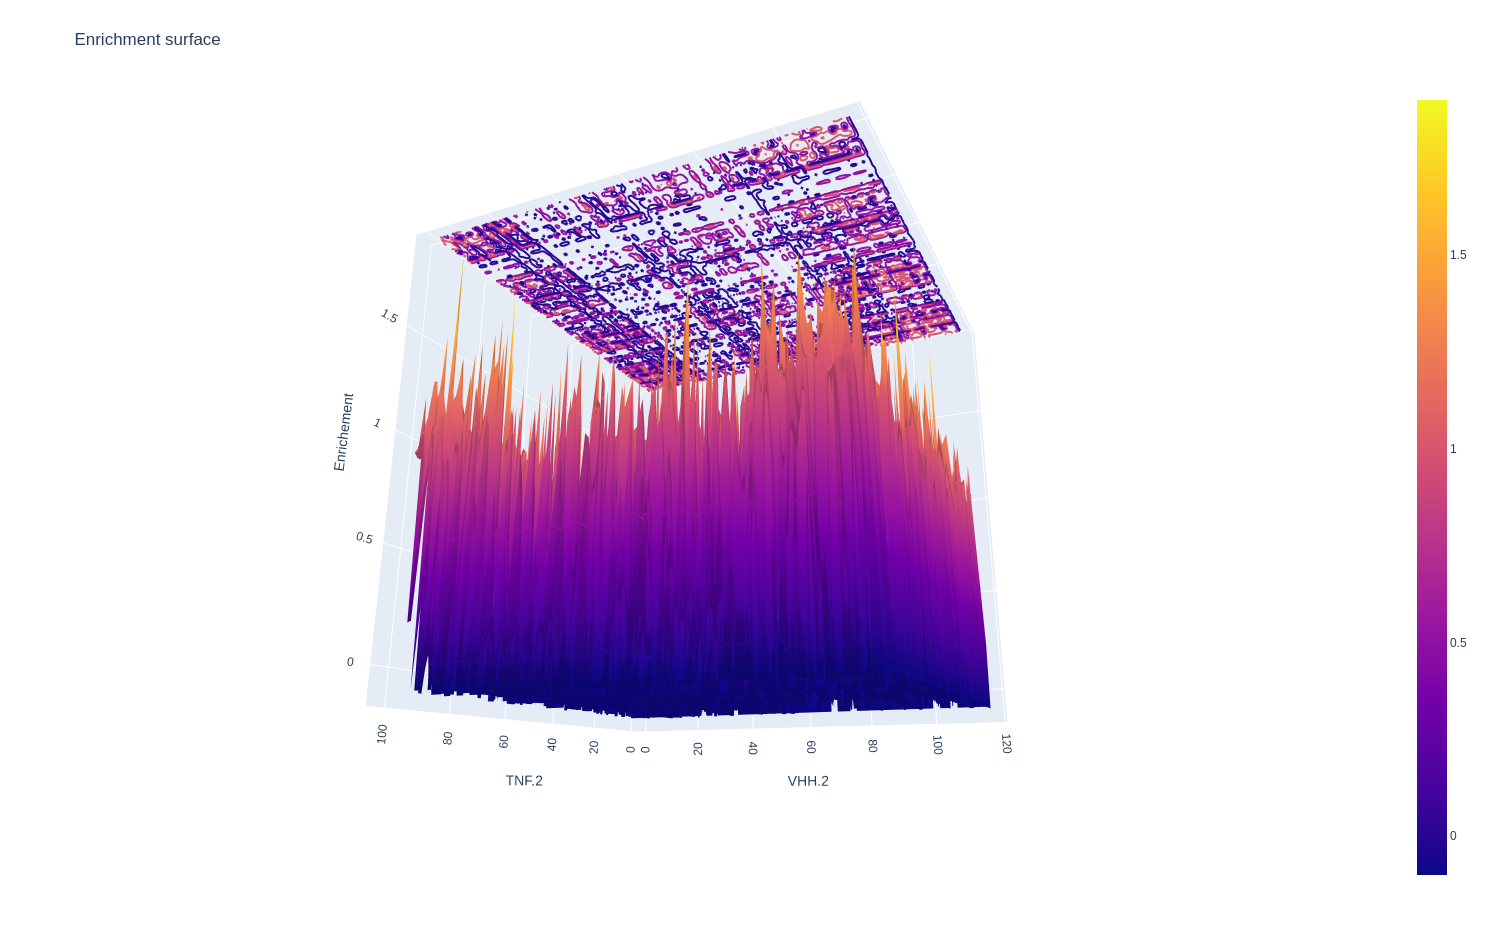

In [11]:
print(partner2)
print((["WT"]+l_mutation_vector_2))
print(partner1)
print(list(["WT"]+l_mutation_vector_1))
#print(enrich_mutation_array)
#print(type(enrich_mutation_array))
print(enrich_mutation_array.shape)
#EnrichDF = pd.DataFrame(enrich_mutation_array, columns = range(enrich_mutation_array.shape[1]), index = range(enrich_mutation_array.shape[0]))
EnrichDF = pd.DataFrame(enrich_mutation_array, columns = ["WT"]+l_mutation_vector_2, index = list(["WT"]+l_mutation_vector_1))
print(EnrichDF)

MyName = "{}_vs_{} enrichment".format(partner1,partner2)
EnrichDF.to_csv(MyName+".tsv", index=True, sep ='\t')
writer = pd.ExcelWriter(MyName+".xlsx", engine='xlsxwriter')
EnrichDF.to_excel(writer,sheet_name = MyName , index=True)
writer.close() 

import plotly.graph_objects as go



# Read data from a csv
#z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')


fig = go.Figure(data=[go.Surface(z=EnrichDF.values, customdata = [partner1, partner2, "Enrichement"], hovertemplate= 'VHH.2: %{y}, TNF.2: %{x}, Enrichement: %{z}')])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True)
                 )
fig.update_layout(title='Enrichment surface', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=950, height=950,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene = dict(xaxis_title=partner2,
                    yaxis_title=partner1,
                    zaxis_title='Enrichement'
                    )
)

fig.show()


In [12]:
"""
Data plotting bis (taking into account the number of barcodes supporting the observation)
"""

data_tot=dict(
    xax = mut_xaxis_partner2,
    yax = mut_yaxis_partner1,
    colors = color,
    enrich = enrich_mutation_array.flatten(),
    alphas = alpha,
    mut2vsWT_xax = mu1vsWT_yaxis_partner1, 
    mut1vsWT_yax = mut2vsWT_xaxis_partner2,
    nbc_size = nbc_mutation_array.flatten()/10.,
)

    #aa_mut_xax = aa_mut_xaxis_partner2,
    #aa_mut_yax = aa_mut_yaxis_partner1,
p = bk.plotting.figure(title="Effects of double mutations according to the normalized enrichment factors (dot size proportional to the N° of BCs)", 
                       x_axis_location="above", tools="hover, save, box_zoom, pan, reset",
                       x_range=["WT"]+l_mutation_vector_2, y_range=list(reversed(["WT"]+l_mutation_vector_1)),
                       tooltips = [
                           ('{} mut'.format(partner1), '@yax'), 
                           ('{} mut'.format(partner2), '@xax'), 
                           ('Enrichments', '@enrich'), 
                           ('Mut in {} vs WT'.format(partner1), '@mut1vsWT_yax'),
                           ('Mut in {} vs WT'.format(partner2), '@mut2vsWT_xax'),  
                           
                       ]
                      )
p.width = 950
p.height = 950
p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "7px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = np.pi/3
p.yaxis.axis_label = partner1
p.xaxis.axis_label = partner2

"""
To modulate the size of the boxes wth respect to the number of barcodes : 
--> switch the comments between the two following lines
"""

p.rect('xax', 'yax', 'nbc_size', 'nbc_size', source=data_tot, color='colors', line_color=None, alpha='alphas', 
       hover_line_color='black', hover_color='colors')
#p.rect('xax', 'yax', 0.9, 0.9, source=data_tot, color='colors', line_color=None, alpha='alphas', 
#       hover_line_color='black', hover_color='colors')
p.add_layout(color_bar, 'right')

bk.plotting.show(p)

### Barplots of the individual mutations against WT barcodes for Partner 1 ###

In [13]:
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, Whisker
from bokeh.plotting import figure
from bokeh.layouts import column, gridplot

l_p =[]
l_aa_1 = [aa[1] for aa in sorted([[int(x[1:]),x] for x in list(s_aa_1)])]

for ii, elt in enumerate(l_aa_1):
    l_mut = []
    l_enrich = []
    l_stdev = []
    lower = []
    upper = []
    l_base = []
    count=0
    for mut in l_mutation_vector_1:
        if not mut[:-1] == elt:
            continue
        l_mut.append(mut)
        l_enrich.append(d_mutvsWT['p1'][mut]['enrich'])
        l_stdev.append(d_mutvsWT['p1'][mut]['stdev'])
        lower.append(d_mutvsWT['p1'][mut]['enrich'] - d_mutvsWT['p1'][mut]['stdev'])
        upper.append(d_mutvsWT['p1'][mut]['enrich'] + d_mutvsWT['p1'][mut]['stdev'])
        l_base.append(count+0.5)
        count+=1
    source_error = ColumnDataSource(data=dict(l_base=l_base, lower=lower, upper=upper))    
    
    p = figure(x_range=l_mut, width=400, height=250, title="{} {} mutants enrichments against WT".format(partner1,elt))
    p.add_layout(Whisker(source=source_error, base="l_base", upper="upper", lower="lower"))
    p.vbar(x=l_mut, top=l_enrich, width=0.5, alpha=0.8)
    
    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    p.y_range.end = 2
    p.add_layout(Whisker(source=source_error, base="l_base", upper="upper", lower="lower"))
    l_p.append(p)
    p.yaxis.axis_label = "Norm. enrichment"

grid = gridplot(l_p, ncols=2)
show(grid)



### Barplots of the individual mutations against WT barcodes for Partner 2 ###

In [14]:
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, Whisker
from bokeh.plotting import figure
from bokeh.layouts import column, gridplot

l_p =[]

l_aa_2 = [aa[1] for aa in sorted([[int(x[1:]),x] for x in list(s_aa_2)])]

for ii, elt in enumerate(l_aa_2):
    l_mut = []
    l_enrich = []
    l_stdev = []
    lower = []
    upper = []
    l_base = []
    count=0
    for mut in l_mutation_vector_2:
        if not mut[:-1] == elt:
            continue
        l_mut.append(mut)
        l_enrich.append(d_mutvsWT['p2'][mut]['enrich'])
        l_stdev.append(d_mutvsWT['p2'][mut]['stdev'])
        lower.append(d_mutvsWT['p2'][mut]['enrich'] - d_mutvsWT['p2'][mut]['stdev'])
        upper.append(d_mutvsWT['p2'][mut]['enrich'] + d_mutvsWT['p2'][mut]['stdev'])
        l_base.append(count+0.5)
        count+=1
    source_error = ColumnDataSource(data=dict(l_base=l_base, lower=lower, upper=upper))    
    
    p = figure(x_range=l_mut, width=400, height=250, title="{} {} mutants enrichments against WT".format(partner2, elt))
    p.add_layout(Whisker(source=source_error, base="l_base", upper="upper", lower="lower"))
    p.vbar(x=l_mut, top=l_enrich, width=0.5, alpha=0.8)
    
    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    p.y_range.end = 2
    p.add_layout(Whisker(source=source_error, base="l_base", upper="upper", lower="lower"))
    l_p.append(p)
    p.yaxis.axis_label = "Norm. enrichment"

grid = gridplot(l_p, ncols=2)
show(grid)

## Specific analysis between pairs of residue ##

In [15]:
## Display all the possible residues ##
print("Mutated AA in partner 1:\n",s_aa_1)
print("Mutated AA in partner 2:\n",s_aa_2)

Mutated AA in partner 1:
 {'N54', 'R98', 'E50', 'S99', 'F103', 'N31', 'N74', 'T53', 'L56', 'Y32', 'S30', 'S101', 'I57', 'W33', 'Y35'}
Mutated AA in partner 2:
 {'R32', 'S95', 'L75', 'T79', 'E135', 'K90', 'N92', 'N137', 'T89', 'I97', 'T77', 'S147', 'Q88', 'S81', 'E146'}


### Define below the index of the residues to analyze ###

In [25]:
residue1 = "30"
residue2 = "147"
df_select = df_DOUBLEMUT_ENRICH[df_DOUBLEMUT_ENRICH["Aminoacid mutation in partner 1"].str.contains(residue1)]
df_select2 = df_select[df_select["Aminoacid mutation in partner 2"].str.contains(residue2)]

df3 = df_select2.copy()

df3["mean enrich tandem mutant"] = df3["mean enrich tandem mutant"].astype(float)



In [26]:
"""
Data preparation
"""

# Graphic analysis for the enrichment of mutations.
l_position_vector_1 = list()
l_mutation_vector_1 = list()
l_position_vector_2 = list()
l_mutation_vector_2  = list()
s_aa_1 = set()
s_aa_2 = set()

#for row in df_DOUBLEMUT_ENRICH.itertuples():
for mutaa1 in d_ordermut['l_aa1']:
    pos_mutaa1 = mutaa1[1:-1]
    if pos_mutaa1 != residue1:
        continue
    d_ordermut['l_aa1_seen'].append(mutaa1)
    
    if mutaa1 not in s_mutation_seen_in_p1:
        continue
    #print(row)
    if mutaa1[1:-1] not in l_position_vector_1:
        #print(row[1][1:-1])
        l_position_vector_1.append(mutaa1[1:-1])
        s_aa_1.add(mutaa1[:-1])                 
    if mutaa1 not in l_mutation_vector_1:
        l_mutation_vector_1.append(mutaa1)
for mutaa2 in d_ordermut['l_aa2']:
    pos_mutaa2 = mutaa2[1:-1]
    if pos_mutaa2 != residue2:
        continue
    d_ordermut['l_aa2_seen'].append(mutaa2)
    if mutaa2 not in s_mutation_seen_in_p2:
        continue
    if mutaa2[1:-1] not in l_position_vector_2:
        l_position_vector_2.append(mutaa2[1:-1])
        s_aa_2.add(mutaa2[:-1]) 
    if mutaa2 not in l_mutation_vector_2:
        l_mutation_vector_2.append(mutaa2)

print("Number of mutations in partner 1: {}".format(len(l_mutation_vector_1)))

print("Number of mutations in partner 2: {}".format(len(l_mutation_vector_2)))


enrich_mutation_array = np.zeros((len(l_mutation_vector_1)+1, len(l_mutation_vector_2)+1))
enrich_mutation_array += -0.1

nbc_mutation_array = np.zeros((len(l_mutation_vector_1)+1, len(l_mutation_vector_2)+1))

mut_xaxis_partner2 = list()
mut2vsWT_xaxis_partner2 = list()
mut_yaxis_partner1 = list()
mu1vsWT_yaxis_partner1 = list()
color = list()
print(len(color))
alpha = list()
df = df_DOUBLEMUT_ENRICH

color.append("black")
alpha.append(1.)
aa_mut_yaxis_partner1.append("WT")
aa_mut_xaxis_partner2.append("WT")
mut_yaxis_partner1.append("WT")
mut_xaxis_partner2.append("WT")
mu1vsWT_yaxis_partner1.append(1)
mut2vsWT_xaxis_partner2.append(1)
d_mutvsWT = dict(p1=dict(), p2=dict())

for jj, elt2 in enumerate(l_mutation_vector_2):#l_mutation_vector_2):
    df_block = df.loc[(df['Aminoacid mutation in partner 2'] == elt2)]
    try:
        enr_mut2vsWT = df_block.iloc[0]['mean2 vs WT']
        stdev_mut2vsWT = df_block.iloc[0]['stdev2']
        size2_mut2vsWT = df_block.iloc[0]['size2']
    except IndexError:
        enr_mut2vsWT = -0.1
        stdev_mut2vsWT = -0.1
        size2_mut2vsWT = 0.        
    enrich_mutation_array[0, jj+1] = "{:.2f}".format(enr_mut2vsWT)
    nbc_mutation_array[0, jj+1] = min(10., size2_mut2vsWT)
    alpha.append(1.)
    color.append(get_color(enr_mut2vsWT))
    mut_xaxis_partner2.append(elt2)
    mut_yaxis_partner1.append("WT")
    mu1vsWT_yaxis_partner1.append("{:.2f}".format(enr_mut2vsWT))
    mut2vsWT_xaxis_partner2.append("-")
    d_mutvsWT['p2'][elt2] = dict()
    d_mutvsWT['p2'][elt2]['enrich'] = enr_mut2vsWT
    d_mutvsWT['p2'][elt2]['stdev'] = stdev_mut2vsWT
    
for ii, elt in enumerate(l_mutation_vector_1):#l_mutation_vector_1):

    # All lines of df_block contain the same info for mean1. We take [0] as a sample
    df_block = df.loc[(df['Aminoacid mutation in partner 1'] == elt)]
    try:
        enr_mut1vsWT = df_block.iloc[0]['mean1 vs WT']
        stdev_mut1vsWT = df_block.iloc[0]['stdev1']
        size1_mut1vsWT = df_block.iloc[0]['size1']
    except IndexError:
        enr_mut1vsWT = -0.1
        stdev_mut1vsWT = -0.1
        size1_mut1vsWT = 0.
    #print(ii, elt, enr_mut1vsWT, get_color(enr_mut1vsWT))
    alpha.append(1.)
    color.append(get_color(enr_mut1vsWT))
    enrich_mutation_array[ii+1, 0] = "{:.2f}".format(enr_mut1vsWT)
    nbc_mutation_array[ii+1, 0] = min(10., size1_mut1vsWT)
    
    mut_xaxis_partner2.append("WT")
    mut_yaxis_partner1.append(elt)
    mu1vsWT_yaxis_partner1.append("-")
    mut2vsWT_xaxis_partner2.append("{:.2f}".format(enr_mut1vsWT))
    d_mutvsWT['p1'][elt] = dict()
    d_mutvsWT['p1'][elt]['enrich'] = enr_mut1vsWT
    d_mutvsWT['p1'][elt]['stdev'] = stdev_mut1vsWT
    
    for jj, elt2 in enumerate(l_mutation_vector_2):#l_mutation_vector_2):
        
        df_row = df_block.loc[(df_block['Aminoacid mutation in partner 2'] == elt2)]
        
        counter_id_xaxis = 0
        #if str(df_row['Aminoacid mutation in partner 1']) == elt and str(df_row['Aminoacid mutation in partner 2']) == elt2:
        #mut_xaxis_partner2.append(row[4])
        #aa_mut_xaxis_partner2.append(row[2])
        #mut_yaxis_partner1.append(elt)
        #aa_mut_yaxis_partner1.append(row[1])
        mut_xaxis_partner2.append(elt2)
        mut_yaxis_partner1.append(elt)
        try:
            mu1vsWT_yaxis_partner1.append("{:.2f} +/- {:.2f}".format(d_mutvsWT['p2'][elt2]['enrich'], 
                                                                      d_mutvsWT['p2'][elt2]['stdev']))
            mut2vsWT_xaxis_partner2.append("{:.2f} +/- {:.2f}".format(d_mutvsWT['p1'][elt]['enrich'],
                                                                     d_mutvsWT['p1'][elt]['stdev']))
        except KeyError:
            mu1vsWT_yaxis_partner1.append("-0.1")
            mut2vsWT_xaxis_partner2.append("-0.1")
        try:
            enrichment = df_row.iloc[0]['mean enrich tandem mutant']
            stdev = df_row.iloc[0]['stdev']
            nbc = df_row.iloc[0]['size in terms of number of bc']
        except IndexError:
            enrichment = -0.1
            stdev = 0
            nbc = 0.
        
        alpha.append(1.)
        enrich_mutation_array[ii+1, jj+1] = "{:.2f}".format(enrichment)
        nbc_mutation_array[ii+1, jj+1] = min(10., nbc)
        color.append(get_color(enrichment))

print("color", len(color))


Number of mutations in partner 1: 9
Number of mutations in partner 2: 6
0
color 70


In [27]:
"""
Data plotting
"""
data_tot=dict(
    xax=mut_xaxis_partner2,
    yax=mut_yaxis_partner1,
    colors=color,
    enrich=enrich_mutation_array.flatten(),
    alphas = alpha,
    mut2vsWT_xax = mu1vsWT_yaxis_partner1, 
    mut1vsWT_yax = mut2vsWT_xaxis_partner2,
    nbc_size = nbc_mutation_array.flatten()/10.,
    nbc_int = nbc_mutation_array.flatten(),
)

    #aa_mut_xax = aa_mut_xaxis_partner2,
    #aa_mut_yax = aa_mut_yaxis_partner1,
p = bk.plotting.figure(title="Effects of double mutations according to the normalized enrichment factors (dot size proportional to the N° of BCs)", 
                       x_axis_location="above", tools="hover, save, box_zoom, pan, reset",
                       x_range=["WT"]+l_mutation_vector_2, y_range=list(reversed(["WT"]+l_mutation_vector_1)),
                       tooltips = [
                           ('{} mut'.format(partner1), '@yax'), 
                           ('{} mut'.format(partner2), '@xax'), 
                           ('Enrichments', '@enrich'), 
                           ('Mut in {} vs WT'.format(partner1), '@mut1vsWT_yax'),
                           ('Mut in {} vs WT'.format(partner2), '@mut2vsWT_xax'),
                           ('Nbc', '@nbc_int'),
                       ]
                      )
p.width = min(1000, len(l_mutation_vector_2)*80)
p.height = min(1000, len(l_mutation_vector_1)*80)
p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "14px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = np.pi/3
p.yaxis.axis_label = partner1
p.xaxis.axis_label = partner2

"""
To modulate the size of the boxes wth respect to the number of barcodes : 
--> switch the comments between the two following lines
"""
#p.rect('xax', 'yax', 0.9, 0.9, source=data_tot, color='colors', line_color='lightgray', alpha='alphas', 
#       hover_line_color='black', hover_color='colors')

p.rect('xax', 'yax', 'nbc_size', 'nbc_size', source=data_tot, color='colors', line_color='lightgray', alpha='alphas', 
       hover_line_color='black', hover_color='colors')

p.add_layout(color_bar, 'right')


bk.plotting.show(p)

## Analysis taking into account WT values ##
### Analysis of the rescues for individually affected mutations ###

In [19]:
"""
Data preparation
"""

# Graphic analysis for the enrichment of mutations.
l_position_vector_1 = list()
l_mutation_vector_1 = list()
l_position_vector_2 = list()
l_mutation_vector_2  = list()
s_aa_1 = set()
s_aa_2 = set()

#for row in df_DOUBLEMUT_ENRICH.itertuples():
for mutaa1 in d_ordermut['l_aa1']:
    if mutaa1 not in s_mutation_seen_in_p1:
        continue
    d_ordermut['l_aa1_seen'].append(mutaa1)
    
    if mutaa1 not in s_mutation_seen_in_p1:
        continue
    #print(row)
    if mutaa1[1:-1] not in l_position_vector_1:
        #print(row[1][1:-1])
        l_position_vector_1.append(mutaa1[1:-1])
        s_aa_1.add(mutaa1[:-1])                 
    if mutaa1 not in l_mutation_vector_1:
        l_mutation_vector_1.append(mutaa1)
for mutaa2 in d_ordermut['l_aa2']:
    if mutaa2 not in s_mutation_seen_in_p2:
        continue
    d_ordermut['l_aa2_seen'].append(mutaa2)
    if mutaa2 not in s_mutation_seen_in_p2:
        continue
    if mutaa2[1:-1] not in l_position_vector_2:
        l_position_vector_2.append(mutaa2[1:-1])
        s_aa_2.add(mutaa2[:-1]) 
    if mutaa2 not in l_mutation_vector_2:
        l_mutation_vector_2.append(mutaa2)

print("Number of mutations in partner 1: {}".format(len(l_mutation_vector_1)))

print("Number of mutations in partner 2: {}".format(len(l_mutation_vector_2)))


enrich_mutation_array = np.zeros((len(l_mutation_vector_1)+1, len(l_mutation_vector_2)+1))
enrich_mutation_array += -0.1

nbc_mutation_array = np.zeros((len(l_mutation_vector_1)+1, len(l_mutation_vector_2)+1))


mut_xaxis_partner2 = list()
mut2vsWT_xaxis_partner2 = list()
mut_yaxis_partner1 = list()
mu1vsWT_yaxis_partner1 = list()
color = list()
print(len(color))
alpha = list()
df = df_DOUBLEMUT_ENRICH

color.append("black")
alpha.append(1.)
aa_mut_yaxis_partner1.append("WT")
aa_mut_xaxis_partner2.append("WT")
mut_yaxis_partner1.append("WT")
mut_xaxis_partner2.append("WT")
mu1vsWT_yaxis_partner1.append(1)
mut2vsWT_xaxis_partner2.append(1)
d_mutvsWT = dict(p1=dict(), p2=dict())

for jj, elt2 in enumerate(l_mutation_vector_2):#l_mutation_vector_2):
    df_block = df.loc[(df['Aminoacid mutation in partner 2'] == elt2)]
    try:
        enr_mut2vsWT = df_block.iloc[0]['mean2 vs WT']
        stdev_mut2vsWT = df_block.iloc[0]['stdev2']
        size2_mut2vsWT = df_block.iloc[0]['size2']
    except IndexError:
        enr_mut2vsWT = -0.1
        stdev_mut2vsWT = -0.1
        size2_mut2vsWT = 0.        
    enrich_mutation_array[0, jj+1] = "{:.2f}".format(enr_mut2vsWT)
    nbc_mutation_array[0, jj+1] = min(10., size2_mut2vsWT)
    alpha.append(1.)
    color.append(get_color(enr_mut2vsWT))
    mut_xaxis_partner2.append(elt2)
    mut_yaxis_partner1.append("WT")
    mu1vsWT_yaxis_partner1.append("{:.2f}".format(enr_mut2vsWT))
    mut2vsWT_xaxis_partner2.append("-")
    d_mutvsWT['p2'][elt2] = dict()
    d_mutvsWT['p2'][elt2]['enrich'] = enr_mut2vsWT
    d_mutvsWT['p2'][elt2]['stdev'] = stdev_mut2vsWT
    
for ii, elt in enumerate(l_mutation_vector_1):#l_mutation_vector_1):

    # All lines of df_block contain the same info for mean1. We take [0] as a sample
    df_block = df.loc[(df['Aminoacid mutation in partner 1'] == elt)]
    try:
        enr_mut1vsWT = df_block.iloc[0]['mean1 vs WT']
        stdev_mut1vsWT = df_block.iloc[0]['stdev1']
        size1_mut1vsWT = df_block.iloc[0]['size1']
    except IndexError:
        enr_mut1vsWT = -0.1
        stdev_mut1vsWT = -0.1
        size1_mut1vsWT = 0.
    #print(ii, elt, enr_mut1vsWT, get_color(enr_mut1vsWT))
    alpha.append(1.)
    color.append(get_color(enr_mut1vsWT))
    enrich_mutation_array[ii+1, 0] = "{:.2f}".format(enr_mut1vsWT)
    nbc_mutation_array[ii+1, 0] = min(10., size1_mut1vsWT)
    
    mut_xaxis_partner2.append("WT")
    mut_yaxis_partner1.append(elt)
    mu1vsWT_yaxis_partner1.append("-")
    mut2vsWT_xaxis_partner2.append("{:.2f}".format(enr_mut1vsWT))
    d_mutvsWT['p1'][elt] = dict()
    d_mutvsWT['p1'][elt]['enrich'] = enr_mut1vsWT
    d_mutvsWT['p1'][elt]['stdev'] = stdev_mut1vsWT
    
    for jj, elt2 in enumerate(l_mutation_vector_2):#l_mutation_vector_2):
        
        df_row = df_block.loc[(df_block['Aminoacid mutation in partner 2'] == elt2)]
        
        counter_id_xaxis = 0
        mut_xaxis_partner2.append(elt2)
        mut_yaxis_partner1.append(elt)
        try:
            mu1vsWT_yaxis_partner1.append("{:.2f}".format(d_mutvsWT['p2'][elt2]['enrich']))
            mut2vsWT_xaxis_partner2.append("{:.2f}".format(d_mutvsWT['p1'][elt]['enrich']))
        except KeyError:
            mu1vsWT_yaxis_partner1.append("-0.1")
            mut2vsWT_xaxis_partner2.append("-0.1")
        try:
            enrichment = df_row.iloc[0]['mean enrich tandem mutant']
            nbc = df_row.iloc[0]['size in terms of number of bc']
        except IndexError:
            enrichment = -0.1
            nbc = 0.
        
        alpha.append(1.)
        
        p1 = d_mutvsWT['p1'][elt]['enrich']
        p2 = d_mutvsWT['p2'][elt2]['enrich']
        
        """
        Conditions to define the scores are defined here  
        """
        
        if p1 <1 and p2 <1:
            diff = (enrichment - min(p1,p2))*(1-min(p1,p2))
            if diff < 0:
                diff = 0
        elif p1 >1 and p2 >1:
            diff =  min(p1,p2) - enrichment
            #if diff > 0:
            diff  = 0
        else:
            diff = 0
            
        
        enrich_mutation_array[ii+1, jj+1] = "{:.2f}".format(diff)
        nbc_mutation_array[ii+1, jj+1] = min(10., nbc) # to modulate the size of the box
        color.append(get_color(diff))

#print("color", len(color))
#print(color)

Number of mutations in partner 1: 117
Number of mutations in partner 2: 102
0


In [20]:
"""
Data plotting
"""
# Interesting cases W33R-N92D


from bokeh.transform import linear_cmap
from bokeh.palettes import Reds6

data_tot=dict(
    xax = mut_xaxis_partner2,
    yax = mut_yaxis_partner1,
    colors = color,
    enrich = enrich_mutation_array.flatten(),
    alphas = alpha,
    mut2vsWT_xax = mu1vsWT_yaxis_partner1, 
    mut1vsWT_yax = mut2vsWT_xaxis_partner2,
    nbc_size = nbc_mutation_array.flatten()/10.,
)

    #aa_mut_xax = aa_mut_xaxis_partner2,
    #aa_mut_yax = aa_mut_yaxis_partner1,
p = bk.plotting.figure(title="Effects of double mutations according to the normalized enrichment factors (dot size proportional to the N° of BCs)", 
                       x_axis_location="above", tools="hover, save, box_zoom, pan, reset",
                       x_range=["WT"]+l_mutation_vector_2, y_range=list(reversed(["WT"]+l_mutation_vector_1)),
                       tooltips = [
                           ('{} mut'.format(partner1), '@yax'), 
                           ('{} mut'.format(partner2), '@xax'), 
                           ('Enrichments', '@enrich'), 
                           ('Mut in {} vs WT'.format(partner1), '@mut1vsWT_yax'),
                           ('Mut in {} vs WT'.format(partner2), '@mut2vsWT_xax'),
                           
                       ]
                      )
p.width = 950
p.height = 950
p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "7px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = np.pi/3
p.yaxis.axis_label = partner1
p.xaxis.axis_label = partner2

"""
To modulate the size of the boxes wth respect to the number of barcodes : 
--> switch the comments between the two following lines
"""

p.rect('xax', 'yax', 'nbc_size', 'nbc_size', source=data_tot, color=linear_cmap('enrich', palette=Reds6, low=0.5, high=0), line_color=None, alpha='alphas', 
       hover_line_color='black', hover_color='colors')
#p.rect('xax', 'yax', 0.9, 0.9, source=data_tot, color=linear_cmap('enrich', palette=Reds6, low=0.5, high=0), line_color=None, alpha='alphas', 
#       hover_line_color='black', hover_color='colors')



bk.plotting.show(p)

EffectReliability = Enrichment * N° BC

In [21]:
enrichXnbc_array = enrich_mutation_array
for i in range(len(enrich_mutation_array)):
    for j in range(len(enrich_mutation_array[i])):
        enrichXnbc_array[i,j] = enrich_mutation_array[i,j] * nbc_mutation_array[i,j]

In [22]:
"""
Data plotting
"""
# Interesting cases W33R-N92D


from bokeh.transform import linear_cmap
from bokeh.palettes import Reds6

data_tot=dict(
    xax = mut_xaxis_partner2,
    yax = mut_yaxis_partner1,
    colors = color,
    enrich = enrichXnbc_array.flatten(),
    alphas = alpha,
    mut2vsWT_xax = mu1vsWT_yaxis_partner1, 
    mut1vsWT_yax = mut2vsWT_xaxis_partner2,
    nbc_size = nbc_mutation_array.flatten()/10.,
)

    #aa_mut_xax = aa_mut_xaxis_partner2,
    #aa_mut_yax = aa_mut_yaxis_partner1,
p = bk.plotting.figure(title="Effects of double mutations according to the normalized enrichment factors * N° of barcodes", 
                       x_axis_location="above", tools="hover, save, box_zoom, pan, reset",
                       x_range=["WT"]+l_mutation_vector_2, y_range=list(reversed(["WT"]+l_mutation_vector_1)),
                       tooltips = [
                           ('{} mut'.format(partner1), '@yax'), 
                           ('{} mut'.format(partner2), '@xax'), 
                           ('Enrichments', '@enrich'), 
                           ('Mut in {} vs WT'.format(partner1), '@mut1vsWT_yax'),
                           ('Mut in {} vs WT'.format(partner2), '@mut2vsWT_xax'),
                           
                       ]
                      )
p.width = 950
p.height = 950
p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "7px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = np.pi/3
p.yaxis.axis_label = partner1
p.xaxis.axis_label = partner2

"""
To modulate the size of the boxes wth respect to the number of barcodes : 
--> switch the comments between the two following lines
"""

#p.rect('xax', 'yax', 'nbc_size', 'nbc_size', source=data_tot, color=linear_cmap('enrich', palette=Reds6, low=0.05, high=0), line_color=None, alpha='alphas', 
#       hover_line_color='black', hover_color='colors')
p.rect('xax', 'yax', 0.9, 0.9, source=data_tot, color=linear_cmap('enrich', palette=Reds6, low=3, high=0), line_color=None, alpha='alphas', 
       hover_line_color='black', hover_color='colors')

bk.plotting.show(p)

## Analysis taking into account WT values ##
### Analysis of highly stabilized pairs for individually favorable mutations ###

In [23]:
"""
Data preparation
"""

# Graphic analysis for the enrichment of mutations.
l_position_vector_1 = list()
l_mutation_vector_1 = list()
l_position_vector_2 = list()
l_mutation_vector_2  = list()
s_aa_1 = set()
s_aa_2 = set()

#for row in df_DOUBLEMUT_ENRICH.itertuples():
for mutaa1 in d_ordermut['l_aa1']:
    if mutaa1 not in s_mutation_seen_in_p1:
        continue
    d_ordermut['l_aa1_seen'].append(mutaa1)
    
    if mutaa1 not in s_mutation_seen_in_p1:
        continue
    #print(row)
    if mutaa1[1:-1] not in l_position_vector_1:
        #print(row[1][1:-1])
        l_position_vector_1.append(mutaa1[1:-1])
        s_aa_1.add(mutaa1[:-1])                 
    if mutaa1 not in l_mutation_vector_1:
        l_mutation_vector_1.append(mutaa1)
for mutaa2 in d_ordermut['l_aa2']:
    if mutaa2 not in s_mutation_seen_in_p2:
        continue
    d_ordermut['l_aa2_seen'].append(mutaa2)
    if mutaa2 not in s_mutation_seen_in_p2:
        continue
    if mutaa2[1:-1] not in l_position_vector_2:
        l_position_vector_2.append(mutaa2[1:-1])
        s_aa_2.add(mutaa2[:-1]) 
    if mutaa2 not in l_mutation_vector_2:
        l_mutation_vector_2.append(mutaa2)

print("Number of mutations in partner 1: {}".format(len(l_mutation_vector_1)))

print("Number of mutations in partner 2: {}".format(len(l_mutation_vector_2)))


enrich_mutation_array = np.zeros((len(l_mutation_vector_1)+1, len(l_mutation_vector_2)+1))
enrich_mutation_array += -0.1

nbc_mutation_array = np.zeros((len(l_mutation_vector_1)+1, len(l_mutation_vector_2)+1))


mut_xaxis_partner2 = list()
mut2vsWT_xaxis_partner2 = list()
mut_yaxis_partner1 = list()
mu1vsWT_yaxis_partner1 = list()
color = list()
print(len(color))
alpha = list()
df = df_DOUBLEMUT_ENRICH

color.append("black")
alpha.append(1.)
aa_mut_yaxis_partner1.append("WT")
aa_mut_xaxis_partner2.append("WT")
mut_yaxis_partner1.append("WT")
mut_xaxis_partner2.append("WT")
mu1vsWT_yaxis_partner1.append(1)
mut2vsWT_xaxis_partner2.append(1)
d_mutvsWT = dict(p1=dict(), p2=dict())

for jj, elt2 in enumerate(l_mutation_vector_2):#l_mutation_vector_2):
    df_block = df.loc[(df['Aminoacid mutation in partner 2'] == elt2)]
    try:
        enr_mut2vsWT = df_block.iloc[0]['mean2 vs WT']
        stdev_mut2vsWT = df_block.iloc[0]['stdev2']
        size2_mut2vsWT = df_block.iloc[0]['size2']
    except IndexError:
        enr_mut2vsWT = -0.1
        stdev_mut2vsWT = -0.1
        size2_mut2vsWT = 0.        
    enrich_mutation_array[0, jj+1] = "{:.2f}".format(enr_mut2vsWT)
    nbc_mutation_array[0, jj+1] = min(10., size2_mut2vsWT)
    alpha.append(1.)
    color.append(get_color(enr_mut2vsWT))
    mut_xaxis_partner2.append(elt2)
    mut_yaxis_partner1.append("WT")
    mu1vsWT_yaxis_partner1.append("{:.2f}".format(enr_mut2vsWT))
    mut2vsWT_xaxis_partner2.append("-")
    d_mutvsWT['p2'][elt2] = dict()
    d_mutvsWT['p2'][elt2]['enrich'] = enr_mut2vsWT
    d_mutvsWT['p2'][elt2]['stdev'] = stdev_mut2vsWT
    
for ii, elt in enumerate(l_mutation_vector_1):#l_mutation_vector_1):

    # All lines of df_block contain the same info for mean1. We take [0] as a sample
    df_block = df.loc[(df['Aminoacid mutation in partner 1'] == elt)]
    try:
        enr_mut1vsWT = df_block.iloc[0]['mean1 vs WT']
        stdev_mut1vsWT = df_block.iloc[0]['stdev1']
        size1_mut1vsWT = df_block.iloc[0]['size1']
    except IndexError:
        enr_mut1vsWT = -0.1
        stdev_mut1vsWT = -0.1
        size1_mut1vsWT = 0.
    #print(ii, elt, enr_mut1vsWT, get_color(enr_mut1vsWT))
    alpha.append(1.)
    color.append(get_color(enr_mut1vsWT))
    enrich_mutation_array[ii+1, 0] = "{:.2f}".format(enr_mut1vsWT)
    nbc_mutation_array[ii+1, 0] = min(10., size1_mut1vsWT)
    
    mut_xaxis_partner2.append("WT")
    mut_yaxis_partner1.append(elt)
    mu1vsWT_yaxis_partner1.append("-")
    mut2vsWT_xaxis_partner2.append("{:.2f}".format(enr_mut1vsWT))
    d_mutvsWT['p1'][elt] = dict()
    d_mutvsWT['p1'][elt]['enrich'] = enr_mut1vsWT
    d_mutvsWT['p1'][elt]['stdev'] = stdev_mut1vsWT
    
    for jj, elt2 in enumerate(l_mutation_vector_2):#l_mutation_vector_2):
        
        df_row = df_block.loc[(df_block['Aminoacid mutation in partner 2'] == elt2)]
        
        counter_id_xaxis = 0
        mut_xaxis_partner2.append(elt2)
        mut_yaxis_partner1.append(elt)
        try:
            mu1vsWT_yaxis_partner1.append("{:.2f}".format(d_mutvsWT['p2'][elt2]['enrich']))
            mut2vsWT_xaxis_partner2.append("{:.2f}".format(d_mutvsWT['p1'][elt]['enrich']))
        except KeyError:
            mu1vsWT_yaxis_partner1.append("-0.1")
            mut2vsWT_xaxis_partner2.append("-0.1")
        try:
            enrichment = df_row.iloc[0]['mean enrich tandem mutant']
            nbc = df_row.iloc[0]['size in terms of number of bc']
        except IndexError:
            enrichment = -0.1
            nbc = 0.
        
        alpha.append(1.)
        
        p1 = d_mutvsWT['p1'][elt]['enrich']
        p2 = d_mutvsWT['p2'][elt2]['enrich']

        if p1 <1 or p2 <1:
            diff = 0
        elif p1 >1 and p2 >1:
            diff =  enrichment - max(p1, p2)
            if diff < 0:
                diff  = 0
        else:
            diff = 0
        enrich_mutation_array[ii+1, jj+1] = "{:.2f}".format(diff)
        nbc_mutation_array[ii+1, jj+1] = min(10., nbc)
        color.append(get_color(diff))

#print("color", len(color))
#print(color)

Number of mutations in partner 1: 117
Number of mutations in partner 2: 102
0


In [24]:
"""
Data plotting
"""

# Interesting mutations : S30K - S147D
#                         S101Q - T89F

from bokeh.transform import linear_cmap
from bokeh.palettes import Greens8

data_tot=dict(
    xax = mut_xaxis_partner2,
    yax = mut_yaxis_partner1,
    colors = color,
    enrich = enrich_mutation_array.flatten(),
    alphas = alpha,
    mut2vsWT_xax = mu1vsWT_yaxis_partner1, 
    mut1vsWT_yax = mut2vsWT_xaxis_partner2,
    nbc_size = nbc_mutation_array.flatten()/10.,
)

    #aa_mut_xax = aa_mut_xaxis_partner2,
    #aa_mut_yax = aa_mut_yaxis_partner1,
p = bk.plotting.figure(title="Effects of double mutations according to the enrichment factors", 
                       x_axis_location="above", tools="hover, save, box_zoom, pan, reset",
                       x_range=["WT"]+l_mutation_vector_2, y_range=list(reversed(["WT"]+l_mutation_vector_1)),
                       tooltips = [
                           ('{} mut'.format(partner1), '@yax'), 
                           ('{} mut'.format(partner2), '@xax'), 
                           ('Enrichments', '@enrich'), 
                           ('Mut in {} vs WT'.format(partner1), '@mut1vsWT_yax'),
                           ('Mut in {} vs WT'.format(partner2), '@mut2vsWT_xax'),
                           
                       ]
                      )
p.width = 950
p.height = 950
p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "7px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = np.pi/3
p.yaxis.axis_label = partner1
p.xaxis.axis_label = partner2

"""
To modulate the size of the boxes wth respect to the number of barcodes : 
--> switch the comments between the two following lines
"""

#p.rect('xax', 'yax', 'nbc_size', 'nbc_size', source=data_tot, color=linear_cmap('enrich', palette=Reds6, low=1, high=0), line_color=None, alpha='alphas', 
#       hover_line_color='black', hover_color='colors')
p.rect('xax', 'yax', 0.9, 0.9, source=data_tot, color=linear_cmap('enrich', palette=Greens8, low=1., high=0), line_color=None, alpha='alphas', 
       hover_line_color='black', hover_color='colors')

color = LinearColorMapper(palette = Greens8, low = 1., high = 0)
tick=[0,0.2,0.4,0.6,0.8,1.0,1.2,1.4]
color_bar = ColorBar(title="                              Enrichment", height=heigth, width=10, color_mapper=color, ticker=FixedTicker(ticks=tick, desired_num_ticks = len(tick)),
                     label_standoff=6, border_line_color=None, location=(0,p.height - (heigth *1.4)), 
                     orientation="vertical")

p.add_layout(color_bar, 'right')

bk.plotting.show(p)